In [5]:
import io
import numpy as np
import tensorflow as tf
import pandas as pd
from scipy.io import wavfile
from python_speech_features import mfcc
import matplotlib.pyplot as plt
!pip install umap-learn
import umap

import tensorflow_addons as tfa

     |████████████████████████████████| 40kB 1.3MB/s eta 0:00:011
  Created wheel for umap-learn: filename=umap_learn-0.3.10-cp37-none-any.whl size=38881 sha256=c0bb45254506fa500022f576e36172f6cf83340cc3d941326909e895cc1a14cf
  Stored in directory: /home/jovyan/.cache/pip/wheels/d0/f8/d5/8e3af3ee957feb9b403a060ebe72f7561887fef9dea658326e
Successfully built umap-learn


In [39]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(
        256,
        input_shape=(32,13),
        return_sequences=True
    ),
    tf.keras.layers.LSTM(
        256
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(
        256, 
        activation=None
    ), 
    tf.keras.layers.Lambda(
        lambda x: tf.math.l2_normalize(x, axis=1)
    )
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32, 256)           276480    
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
lambda_1 (Lambda)            (None, 256)               0         
Total params: 867,584
Trainable params: 867,584
Non-trainable params: 0
_________________________________________________________________


In [7]:
!ls /data/UrbanSound8K/metadata

UrbanSound8K.csv


In [8]:
metadata_path = "/data/UrbanSound8K/metadata/UrbanSound8K.csv"

df = pd.read_csv(metadata_path)

In [9]:
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [10]:
filepath = "/data/UrbanSound8K/audio/fold{fold}/{filename}"

len(df.index)

8732

In [33]:
test_file = filepath.format(
    fold=5,
    filename="100032-3-0-0.wav"
)

fs, sample = wavfile.read(test_file)

Data = []
Labels = []

idx = 0
for row in df.iterrows():
    row=row[1]
    filename = filepath.format(fold=row['fold'],filename=row['slice_file_name'])
    try:
        fs, sample = wavfile.read(filename)
        data = mfcc(signal=sample, samplerate=fs)
        Data.append(data)
        Labels.append(row['class'])
        idx += 1
    except:
        pass
    if idx >= 1024:
        break


In [34]:
_Data = tf.keras.preprocessing.sequence.pad_sequences(
    Data,
    maxlen=32,
    dtype='float32',
    padding='pre',
    truncating='pre',
    value=0.0
)

from random import randint

Map = {}
l = 0
Label = []

for label in Labels:
    if label not in Map:
        Map[label] = l
        l += 1
    Label.append(Map[label])

In [35]:
_Data.shape

(1024, 32, 13)

In [36]:
dataset = tf.data.Dataset.from_tensor_slices((_Data, Label))
dataset = dataset.shuffle(1024).batch(32)
dataset

<BatchDataset shapes: ((None, 32, 13), (None,)), types: (tf.float32, tf.int32)>

In [40]:

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())


In [41]:

# Train the network
history = model.fit(
    dataset,
    epochs=20
)

Epoch 1/20
32/32 [==============================] - 5s 172ms/step - loss: 0.7492
Epoch 2/20
32/32 [==============================] - 3s 95ms/step - loss: 0.5992
Epoch 3/20
32/32 [==============================] - 3s 95ms/step - loss: 0.5477
Epoch 4/20
32/32 [==============================] - 3s 97ms/step - loss: 0.5240
Epoch 5/20
32/32 [==============================] - 3s 93ms/step - loss: 0.4693
Epoch 6/20
32/32 [==============================] - 3s 94ms/step - loss: 0.4247
Epoch 7/20
32/32 [==============================] - 3s 97ms/step - loss: 0.3760
Epoch 8/20
32/32 [==============================] - 3s 97ms/step - loss: 0.3374
Epoch 9/20
32/32 [==============================] - 3s 102ms/step - loss: 0.3566
Epoch 10/20
32/32 [==============================] - 3s 98ms/step - loss: 0.3628
Epoch 11/20
 8/32 [======>.......................] - ETA: 2s - loss: 0.4107

KeyboardInterrupt: 

In [42]:
X = model.predict(dataset)

In [43]:
X.shape

(1024, 256)

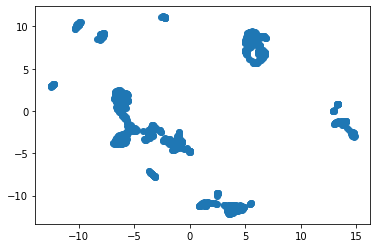

In [44]:
import umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(X)
embedding.shape
plt.scatter(embedding[:,0], embedding[:,1])